In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
import os

In [28]:
df = pd.read_csv("../data/cleaned_compliance_data.csv")

# -------------------------
# 2️⃣ Split into features & target
# -------------------------
target_col = "Perfect_Waste_Decomposition_System"
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, '../models/scaler.pkl')


# 2. Apply PCA (as in your original code)
pca = PCA(n_components=0.95) # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# --- End of Mock Data Setup ---


In [29]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}


In [30]:
results = []

for name, model in models.items():
    # Using PCA data for this part
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0)
    })

In [31]:
# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)
print("Model Performance on PCA Data:")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
best_model_pca = models[best_model_name]
print(f"\n🏆 Best Model (from PCA data): {best_model_name}")

# Create directory if it doesn't exist
if not os.path.exists("../models"):
    os.makedirs("../models")
    
joblib.dump(best_model_pca, "../models/waste_compliance_pca_model.pkl")
print("✅ Best model (from PCA) saved: waste_compliance_pca_model.pkl")

Model Performance on PCA Data:
                 Model  Accuracy  Precision  Recall  F1-Score
0        Random Forest       1.0        1.0     1.0       1.0
1    Gradient Boosting       1.0        1.0     1.0       1.0
2             AdaBoost       1.0        1.0     1.0       1.0
3  Logistic Regression       1.0        1.0     1.0       1.0
4        Decision Tree       1.0        1.0     1.0       1.0

🏆 Best Model (from PCA data): Random Forest
✅ Best model (from PCA) saved: waste_compliance_pca_model.pkl


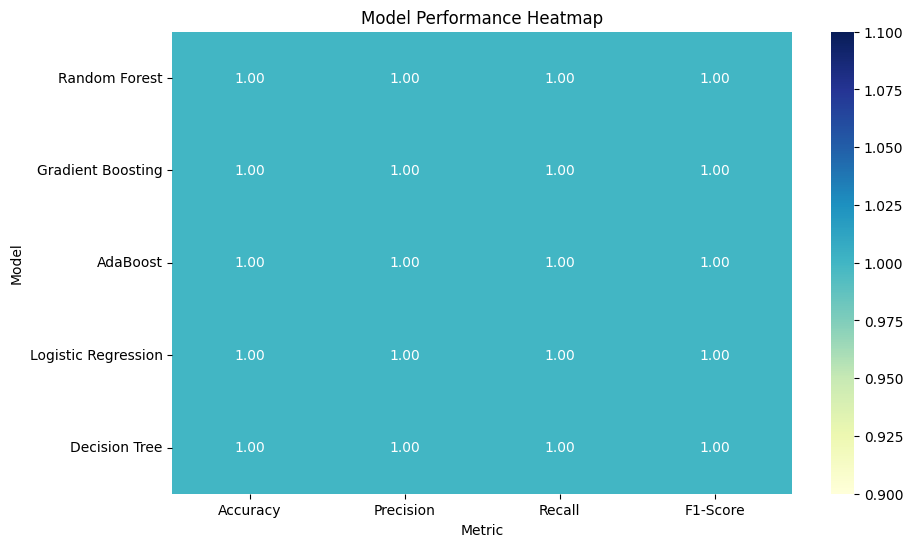

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the index to model names and drop the 'Model' column
heatmap_df = results_df.set_index("Model")

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Model Performance Heatmap")
plt.ylabel("Model")
plt.xlabel("Metric")
plt.show()


In [33]:
best_model_scaled = models[best_model_name]

# 2. Train this new model instance on the scaled (non-PCA) data
print(f"\nTraining {best_model_name} on the scaled dataset...")
best_model_scaled.fit(X_train_scaled, y_train)
print("✅ Training complete.")


Training Random Forest on the scaled dataset...
✅ Training complete.


In [34]:
# 3. Evaluate the model on the scaled test data to see its performance
print("\nEvaluating the new model on the scaled test set...")
y_pred_scaled = best_model_scaled.predict(X_test_scaled)

print("\nClassification Report (Scaled Data):")
print(classification_report(y_test, y_pred_scaled, zero_division=0))

# 4. Save the model trained on scaled data to a new file
joblib.dump(best_model_scaled, "../models/model.pkl")
print("✅ Best model (trained on scaled data) saved: wastbe_compliance_scaled_model.pkl")


Evaluating the new model on the scaled test set...

Classification Report (Scaled Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       191
           1       1.00      1.00      1.00       209

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

✅ Best model (trained on scaled data) saved: wastbe_compliance_scaled_model.pkl


In [35]:
# Load the saved model and scaler to test them
loaded_model = joblib.load('../models/model.pkl')
loaded_scaler = joblib.load('../models/scaler.pkl')

# Scale the test data with the loaded scaler
X_test_scaled_again = loaded_scaler.transform(X_test)

# Make predictions with the loaded model
y_pred = loaded_model.predict(X_test_scaled_again)

# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")

Model Accuracy on Test Set: 1.0000
